In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt 


In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Specify GPU device index
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:

train_df = pd.read_csv('food-101/meta/train.txt', header = None, names=['path'])
test_df = pd.read_csv('food-101/meta/test.txt', header = None, names=['path'])
len(train_df)

75750

In [5]:
def spliter(data, class_or_id='id'):
    if class_or_id.upper() == 'CLASS':
        output = data.split('/')[0]
        
    else:
        output = data.split('/')[-1]
    return output

In [6]:
train_df['label'] = train_df['path'].map(lambda x: spliter(data = x, class_or_id = 'Class')) 
train_df['idx'] = train_df['path'].map(lambda x: spliter(x)) 
test_df['label'] = test_df['path'].map(lambda x: spliter(x, 'class')) 
test_df['idx'] = test_df['path'].map(lambda x: spliter(x)) 

In [7]:
food_25 = train_df['label'].unique()[:24]
print(food_25)

['apple_pie' 'baby_back_ribs' 'baklava' 'beef_carpaccio' 'beef_tartare'
 'beet_salad' 'beignets' 'bibimbap' 'bread_pudding' 'breakfast_burrito'
 'bruschetta' 'caesar_salad' 'cannoli' 'caprese_salad' 'carrot_cake'
 'ceviche' 'cheesecake' 'cheese_plate' 'chicken_curry'
 'chicken_quesadilla' 'chicken_wings' 'chocolate_cake' 'chocolate_mousse'
 'churros']


In [8]:
list_ = []
for f in food_25:
    list_.append(f.upper())
food_25 = [food.upper() for food in food_25]

In [9]:
def prepare_data(label):
    if label.upper() in food_25:
        return label
    else:
        return 'others'

In [10]:
train_df['label'] = train_df['label'].map(lambda x: prepare_data(x))
test_df['label'] = test_df['label'].map(lambda x: prepare_data(x))
print(train_df['label'].unique())

['apple_pie' 'baby_back_ribs' 'baklava' 'beef_carpaccio' 'beef_tartare'
 'beet_salad' 'beignets' 'bibimbap' 'bread_pudding' 'breakfast_burrito'
 'bruschetta' 'caesar_salad' 'cannoli' 'caprese_salad' 'carrot_cake'
 'ceviche' 'cheesecake' 'cheese_plate' 'chicken_curry'
 'chicken_quesadilla' 'chicken_wings' 'chocolate_cake' 'chocolate_mousse'
 'churros' 'others']


In [11]:
def Adding_Path(path):
    return 'food-101/images/'+path+'.jpg'
train_df['path'] = train_df[['path']].apply(Adding_Path, axis=1)
test_df['path'] = test_df[['path']].apply(Adding_Path, axis=1)

In [12]:
test_images = plt.imread(test_df['path'].iloc[114])
test_images = test_images/255.
test_images.shape

(512, 512, 3)

In [13]:
datagen = ImageDataGenerator(rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
#test_gen = ImageDataGenerator(rescale=1. / 255)

test_gen = datagen.flow_from_dataframe(dataframe = test_df, directory=None, x_col='path', y_col='label',
    weight_col=None, target_size=(224, 224), color_mode='rgb', 
    classes=None, class_mode='categorical', batch_size=16,shuffle=False)

train_gen = datagen.flow_from_dataframe(dataframe = train_df, directory=None, x_col='path', y_col='label',
    weight_col=None, target_size=(224, 224), color_mode='rgb', 
    classes=None, class_mode='categorical', batch_size=16, shuffle=True)

Found 25250 validated image filenames belonging to 25 classes.
Found 75750 validated image filenames belonging to 25 classes.


In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(25,  activation=tf.nn.softmax)
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 56, 56, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        4

In [16]:
callback = EarlyStopping(monitor='loss', patience=1)
epochs=10
history = model.fit(train_gen,validation_data=test_gen, epochs=epochs,callbacks=[callback])

Epoch 1/10
4735/4735 [==============================] - 784s 165ms/step - loss: 1.3208 - categorical_accuracy: 0.7622 - val_loss: 1.3058 - val_categorical_accuracy: 0.7624
Epoch 2/10
4735/4735 [==============================] - 755s 159ms/step - loss: 1.3089 - categorical_accuracy: 0.7624 - val_loss: 1.3053 - val_categorical_accuracy: 0.7624
Epoch 3/10
4735/4735 [==============================] - 761s 161ms/step - loss: 1.3083 - categorical_accuracy: 0.7624 - val_loss: 1.3053 - val_categorical_accuracy: 0.7624
Epoch 4/10
4735/4735 [==============================] - 759s 160ms/step - loss: 1.3075 - categorical_accuracy: 0.7624 - val_loss: 1.3083 - val_categorical_accuracy: 0.7624
Epoch 5/10
4735/4735 [==============================] - 760s 161ms/step - loss: 1.3071 - categorical_accuracy: 0.7624 - val_loss: 1.3068 - val_categorical_accuracy: 0.7624
Epoch 6/10
4735/4735 [==============================] - 760s 160ms/step - loss: 1.3064 - categorical_accuracy: 0.7624 - val_loss: 1.3053 - v

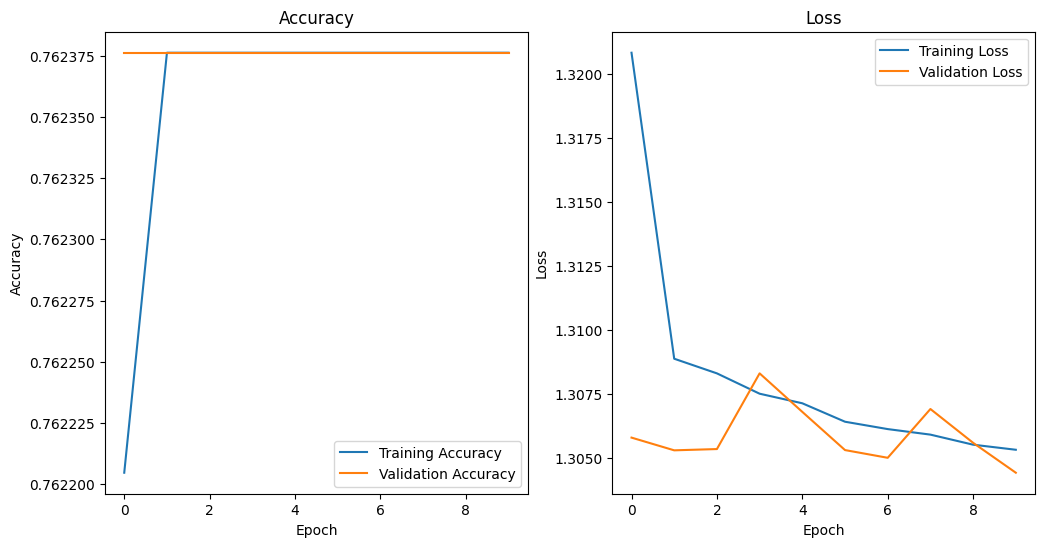

In [17]:
# Get the accuracy and loss from the history
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss'] 

# Create a figure and axis
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the accuracy
ax[0].plot(accuracy, label='Training Accuracy')
ax[0].plot(val_accuracy, label='Validation Accuracy')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot the loss
ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Show the plot
plt.show()

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Get the predicted labels from the model
y_pred = model.predict(test_gen)

# Convert the predicted labels to class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Get the true labels from the test dataset
y_true = test_gen.classes

# Create a confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_class)

print("Confusion Matrix:")
print(conf_mat)

# Calculate Cohen's kappa value
kappa = cohen_kappa_score(y_true, y_pred_class, weights='quadratic')

print("Cohen's Kappa Value:", kappa)

1579/1579 [==============================] - 268s 169ms/step
Confusion Matrix:
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
    250]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
    250]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
    250]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
    250]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
    250]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0 